In [0]:
# 케라스 창시자에게 배우는 딥러닝 공부
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# **3.2 영화 리뷰 분류 : 이진 분류 예제**

리뷰 택스트를 기반으로 영화 리뷰를 긍정과 부정으로 분류하는 방법 익히기

>5만개의  IMDB 데이터셋이용

>케라스에 포함된 데이터로 전처리되어 있어 각 리부(단어시퀀스)가 숫자 시퀀스로 변환되어 있다. 숫자는 사전에 있는 고유한 단어를 나타냄

>train :2만5천개, test : 2만5천개 (각각 50대50으로 긍정부정 리뷰 구성)





In [0]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 1s 0us/step


train data에서 가장 자주 나타나는 단어 만개만 사용하기 위하기 위해 매개변수 num_words=10000으로 지정
드물게 나타나는 단어는 무시할 것이다.
이유 : 적절한 크기의 벡터 데이터를 얻을 수 있기때문에


In [0]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [0]:
train_labels[0]

1

num_words=10000로 제한했기 떄문에 단어의 index는 만을 넘지 않는다.




In [0]:
max([max(sequence) for sequence in train_data])

9999

리뷰 데이터 하나를 원래 영어 단어로 바꾸기

In [0]:
# word_index는 단어와 정수 인덱스를 매핑한 딕셔너리입니다
word_index = imdb.get_word_index()
# 정수 인덱스와 단어를 매핑하도록 뒤집습니다
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 리뷰를 디코딩합니다. 
# 0, 1, 2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스이므로 3을 뺍니다
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

1646592/1641221 [==============================] - 0s 0us/step


In [0]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

# 데이터 준비

신경망에 숫자 리스트를 넣을 수 없다. 리스트를 텐서로 바꾸는 작업이 필요

>방법1 : 같은 길이가 되도록 리스트에 패딩을 추가하고 (samples, sequence_length) 크기의 정수 텐서로 변환하기.  이 정수 텐서를 다룰 수 있는 층을 신경망의 첫 번째 층으로 사용한다. (Embedding 층을 말하며 나중에 자세히 다룸).

>방법2 : 리스트를 원-핫 인코딩하여 0과1의 벡터로 변환하기. (ex. 시퀀스[3,5]를 index 3과 5의 위치는 1이고 그외는 모두 0인 10,000벡터로 각각 변환한다.) 이후 부동 소수 벡터 데이터를 다룰 수 있는 Dense층을 신경망의 첫 번쨰 층으로 사용

>방법 2를 이용해 보기



---

부동소수란?

부동소수점(浮動小數點, floating point) 또는 떠돌이 소수점[1] 방식은 ***실수를 컴퓨터 상에서 근사하여 표현할 때 소수점의 위치를 고정하지 않고 그 위치를 나타내는 수를 따로 적는 것***으로, 유효숫자를 나타내는 가수(假數)와 소수점의 위치를 풀이하는 지수(指數)로 나누어 표현한다.

컴퓨터에서는 고정 소수점 방식보다 넓은 범위의 수를 나타낼 수 있어 과학기술 계산에 많이 이용되지만, 근삿값으로 표현되며[2] 고정 소수점 방식보다 연산 속도가 느리기 때문에 별도의 전용 연산 장치를 두는 경우가 많다. 고정 소수점과 달리 정수 부분과 소수 부분의 자릿수가 일정하지 않으나, 유효 숫자의 자릿수는 정해져 있다.[출처 : 위키백과]



In [0]:
#리스트를 원-핫 인코딩하여 0과1의 벡터로 변환하기
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # 크기가 (len(sequences), dimension))이고 모든 원소가 0인 행렬을 만듭니다
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # results[i]에서 특정 인덱스의 위치를 1로 만듭니다
    return results

# 훈련 데이터를 벡터로 변환합니다
x_train = vectorize_sequences(train_data)
# 테스트 데이터를 벡터로 변환합니다
x_test = vectorize_sequences(test_data)

In [0]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [0]:
# 레이블을 벡터로 바꿉니다
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# 신경망 모델 만들기
입력 데이터는 벡터이고 레이블은 스칼라(1 또는 0).  이런 문제에 잘 작동하는 네트워크 종류는 relu 활성화 함수를 사용한 완전 연결 층(즉, Dense(16, activation='relu'))을 그냥 쌓은 것이다.

Dense 층에 전달한 매개변수(16)는 은닉 유닛의 개수다. 하나의 은닉 유닛은 층이 나타내는 표현 공간에서 하나의 차원이 된다. 

2장에서 relu 활성화 함수를 사용한 Dense 층을 다음과 같은 텐서 연산을 연결하여 구현함:
output = relu(dot(W, input) + b)

16개의 은닉 유닛이 있다는 것은 가중치 행렬 W의 크기가 (input_dimension, 16)이라는 뜻이다. 입력 데이터와 W를 점곱하면 입력 데이터가 16 차원으로 표현된 공간으로 투영된다(그리고 편향 벡터 b를 더하고 relu 연산을 적용). 표현 *공간의 차원을 '신경망이 내재된 표현을 학습할 때 가질 수 있는 자유도'로 이해*할 수 있다. 은닉 유닛을 늘리면 (표현 공간을 더 고차원으로 만들면) 신경망이 더욱 복잡한 표현을 학습할 수 있지만 계산 비용이 커지고 원치 않은 패턴을 학습할 수도 있다(훈련 데이터에서는 성능이 향상되지만 테스트 데이터에서는 그렇지 않은 패턴을 보임).

Dense 층을 쌓을 때 두 가진 중요한 구조상의 결정이 필요:

>1. 얼마나 많은 층을 사용할 것인가?

>2. 각 층에 얼마나 많은 은닉 유닛을 둘 것인가?

4장에서 이런 결정을 하는 데 도움이 되는 일반적인 원리를 배움.

16개의 은닉 유닛을 가진 두 개의 은닉층
현재 리뷰의 감정을 스칼라 값의 예측으로 출력하는 세 번째 층
중간에 있는 은닉층은 활성화 함수로 relu를 사용하고 마지막 층은 확률(0과 1 사이의 점수로, 어떤 샘플이 타깃 '1'일 가능성이 높다는 것은 그 리뷰가 긍정일 가능성이 높다는 것을 의미)을 출력하기 위해 시그모이드 활성화 함수를 사용한다. relu는 음수를 0으로 만드는 함수*. 시그모이드는 임의의 값을 [0, 1] 사이로 압축하므로 출력 값을 확률처럼 해석할 수 있다.*

신경망 모습:
![대체 텍스트](https://camo.githubusercontent.com/ad8a581c483ced840d4a471329d8654e41883d79/68747470733a2f2f73332e616d617a6f6e6177732e636f6d2f626f6f6b2e6b657261732e696f2f696d672f6368332f335f6c617965725f6e6574776f726b2e706e67)




---


이 신경망의 케라스 구현:




In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

마지막으로 손실 함수와 옵티마이저를 선택해야 한다. 이진 분류 문제이고 신경망의 출력이 확률이기 때문에(네트워크의 끝에 시그모이드 활성화 함수를 사용한 하나의 유닛으로 된 층을 놓았다), binary_crossentropy 손실이 적합하다. 이 함수가 유일한 선택은 아니다. mean_squared_error를 사용할 수도 있다.

확률을 출력하는 모델을 사용할 때는 크로스엔트로피가 최선의 선택이다. 크로스엔트로피는 정보 이론 분야에서 온 개념으로 확률 분포 간의 차이를 측정한다. 여기에서는 원본 분포와 예측 분포 사이를 측정한다.

다음은 rmsprop 옵티마이저와 binary_crossentropy 손실 함수로 모델을 설정하는 단계이다. 훈련하는 동안 정확도를 사용해 모니터링하자.

In [0]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

케라스에 rmsprop, binary_crossentropy, accuracy가 포함되어 있기 때문에 옵티마이저, 손실 함수, 측정 지표를 문자열로 지정하는 것이 가능하다. 이따금 옵티마이저의 매개변수를 바꾸거나 자신만의 손실 함수, 측정 함수를 전달해야 할 경우가 있는데 전자의 경우에는 옵티마이저 파이썬 클래스를 사용해 객체를 직접 만들어 optimizer 매개변수에 전달하면 된다. 후자의 경우는 loss와 metrics 매개변수에 함수 객체를 전달한다.

In [0]:
#옵티마이저 파이썬 클래스를 사용해 객체를 직접 만들어 optimizer 매개변수에 전달

from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
#loss와 metrics 매개변수에 함수 객체를 전달

In [0]:
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

In [0]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 훈련 검증
훈련하는 동안 처음 본 데이터에 대한 모델의 정확도를 측정하기 위해서는 원본 훈련 데이터에서 10,000의 샘플을 떼어서 검증 세트를 만들자

In [0]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

이제 모델을 512개 샘플씩 미니 배치를 만들어 20번의 에포크 동안 훈련시키자(x_train과 y_train 텐서에 있는 모든 샘플에 대해 20번 반복). 동시에 따로 떼어 놓은 10,000개의 샘플에서 손실과 정확도를 측정할 것이다. 이렇게 하려면 validation_data 매개변수에 검증 데이터를 전달해야 한다.

In [0]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 4s 234us/step - loss: 0.5363 - acc: 0.7760 - val_loss: 0.4001 - val_acc: 0.8675
Epoch 2/20
15000/15000 [==============================] - 3s 195us/step - loss: 0.3203 - acc: 0.8986 - val_loss: 0.3268 - val_acc: 0.8736
Epoch 3/20
15000/15000 [==============================] - 3s 190us/step - loss: 0.2342 - acc: 0.9249 - val_loss: 0.2856 - val_acc: 0.8867
Epoch 4/20
15000/15000 [==============================] - 3s 190us/step - loss: 0.1837 - acc: 0.9403 - val_loss: 0.2737 - val_acc: 0.8908
Epoch 5/20
15000/15000 [==============================] - 3s 191us/step - loss: 0.1517 - acc: 0.9511 - val_loss: 0.2997 - val_acc: 0.8814
Epoch 6/20
15000/15000 [==============================] - 3s 191us/step - loss: 0.1227 - acc: 0.9623 - val_loss: 0.2877 - val_acc: 0.8869
Epoch 7/20
15000/15000 [==============================] - 3s 191us/step - 

model.fit() 메서드는 History 객체를 반환한다. 이 객체는 훈련하는 동안 발생한 모든 정보를 담고 있는 딕셔너리인 history 속성을 가지고 있다. 

In [0]:
import matplotlib.pyplot as plt

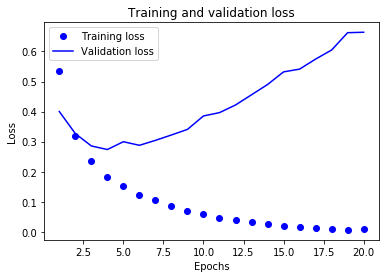

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# ‘bo’는 파란색 점을 의미합니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# ‘b’는 파란색 실선을 의미합니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

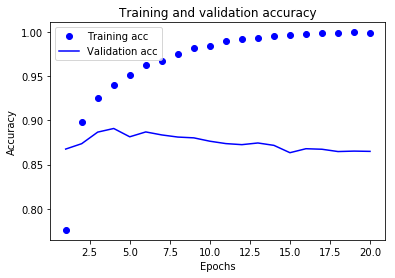

In [0]:
plt.clf()   # 그래프를 초기화합니다
acc = history.history['acc']
val_acc = history.history['val_acc']
#acc = history_dict['acc']
#val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

점선은 훈련 손실과 정확도이고 실선은 검증 손실과 정확도이다. 신경망의 무작위한 초기화 때문에 사람마다 결과거 조금 다름.

훈련 손실이 에포크마다 감소하고 훈련 정확도는 에포크마다 증가한다. 경사 하강법 최적화를 사용했을 때 반복마다 최소화되는 것이 손실이므로 기대와 같다. 검증 손실과 정확도는 이와 같지 않다. 4번째 에포크에서 그래프가 역전데 이것이 훈련 세트에서 잘 작동하는 모델이 처음 보는 데이터에 잘 작동하지 않을 수 있다고 앞서 언급한 경고의 한 사례다. 정확한 용어로 말하면 과대적합. 2번째 에포크 이후부터 훈련 데이터에 과도하게 최적화되어 훈련 데이터에 특화된 표현을 학습하므로 훈련 세트 이외의 데이터에는 일반화되지 못한다.

이런 경우에 과대적합을 방지하기 위해서 3번째 에포크 이후에 훈련을 중지한다. 

처음부터 다시 새로운 신경망을 4번의 에포크 동안만 훈련하고 테스트 데이터에서 평가해 보자:

In [0]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 4s 150us/step - loss: 0.4738 - acc: 0.8217
Epoch 2/4
25000/25000 [==============================] - 3s 139us/step - loss: 0.2673 - acc: 0.9093
Epoch 3/4
25000/25000 [==============================] - 3s 137us/step - loss: 0.2032 - acc: 0.9286
Epoch 4/4
25000/25000 [==============================] - 2s 77us/step


In [0]:
results

[0.3124895779132843, 0.87584]

 87%의 정확도를 달성. 최고 수준의 기법을 사용하면 95%에 가까운 성능을 얻을 수 있다.

In [0]:
model.predict(x_test)

array([[0.16219068],
       [0.99984837],
       [0.39698157],
       ...,
       [0.08048674],
       [0.04885855],
       [0.45590666]], dtype=float32)

이 모델은 어떤 샘플에 대해 확신을 가지고 있지만(0.99 또는 그 이상, 0.01 또는 그 이하) 어떤 샘플에 대해서는 확신이 부족하다(0.6, 0.4).


--------
4월 28일 이후 진행예정


# 추가 실험
여기에서는 두 개의 은닉층을 사용했습니다. 한 개 또는 세 개의 은닉층을 사용하고 검증과 테스트 정확도에 어떤 영향을 미치는지 확인해 보세요.
층의 은닉 유닛을 추가하거나 줄여 보세요: 32개 유닛, 64개 유닛 등
binary_crossentropy 대신에 mse 손실 함수를 사용해 보세요.
relu 대신에 tanh 활성화 함수(초창기 신경망에서 인기 있었던 함수입니다)를 사용해 보세요.
다음 실험을 진행하면 여기에서 선택한 구조가 향상의 여지는 있지만 어느 정도 납득할 만한 수준이라는 것을 알게 것입니다!

# 정리

* 원본 데이터를 신경망에 텐서로 주입하기 위해서는 꽤 많은 전처리가 필요하다. 단어 시퀀스는 이진 벡터로 인코딩될 수 있고 다른 인코딩 방식도 있다.
* relu 활성화 함수와 함께 Dense 층을 쌓은 네트워크는 (감성 분류를 포함하여) 여러 종류의 문제에 적용할 수 있어서 앞으로 자주 사용하게 된다.
* (출력 클래스가 두 개인) 이진 분류 문제에서 네트워크는 하나의 유닛과 sigmoid 활성화 함수를 가진 Dense 층으로 끝나야 한다. 이 신경망의 출력은 확률을 나타내는 0과 1 사이의 스칼라 값이다.
* 이진 분류 문제에서 이런 스칼라 시그모이드 출력에 대해 사용할 손실 함수는 binary_crossentropy이다.
* rmsprop 옵티마이저는 문제에 상관없이 일반적으로 충분히 좋은 선택이다.
* 훈련 데이터에 대해 성능이 향상됨에 따라 신경망은 과대적합되기 시작하고 이전에 본적 없는 데이터에서는 결과가 점점 나빠지게 된다. 항상 훈련 세트 이외의 데이터에서 성능을 모니터링해야 한다.